In [1]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 2.8MB/s 


In [0]:
import pandas as pd


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
import nltk
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.sparse import hstack
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from nltk import word_tokenize,sent_tokenize
from gensim import corpora
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt


In [0]:
df_train = pd.read_csv("/content/labeled_data.csv")[["tweet","class"]]
df_train=df_train.sample(frac=1)

In [0]:
X_train = df_train[df_train['class']==0]
X__train = df_train[df_train['class']==1][:1000]
X__train2 = df_train[df_train['class']==2][:1000]
X_train = X_train.append(X__train)
df_train = X_train.append(X__train2)


In [163]:
nltk.download("stopwords")
from nltk.stem.porter import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt","RT"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()

def preprocess(text_string):
    
    #Lowercase string
    text_string=text_string.lower()
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    
    #Stem it
    tweet = " ".join(re.split("[^a-zA-Z]*", parsed_text)).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens
  
  
def pos_tag_seq(tokens):
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    return tag_str
  
  

In [0]:
def join_sent(l):
  return " ".join(l)

In [166]:
df_train.head()

,tweet,class
5865,@djfeds suck my dick tacos el negro better,0
5639,@bonnoxxx haha bitch ima draw a webb in bullet...,0
14985,RT @DestroTheNoble: I don't support that ya id...,0
14709,RT @ClassicBray: Lmaoo RT @PacDaGoat: That's a...,0
4519,@RepulsiveTool And the only band that sucked w...,0


In [167]:
s_train=df_train['tweet'].apply(preprocess)

/usr/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.



In [0]:
s_tr=s_train.apply(join_sent)

In [0]:
vectorizer = TfidfVectorizer(
    preprocessor=None,
    lowercase=False,
    ngram_range=(1, 3),
    use_idf=True,
    smooth_idf=False,
    norm=None,
    stop_words=stopwords,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75)


In [0]:
tfidf_tr = vectorizer.fit_transform(s_tr).toarray()

vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()}

In [0]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
sentiment_analyzer = VS()


In [0]:
def get_sentiment(text):
  sentiment = sentiment_analyzer.polarity_scores(text)
  return sentiment

#   return sentiment["neg"], sentiment["pos"], sentiment["neu"]

In [0]:
df_train["sent"]=df_train["tweet"].apply(get_sentiment) 

In [0]:
foo_tr = lambda x: pd.Series([x["pos"],x["neg"],x["neu"]])
rev_tr = df_train['sent'].apply(foo_tr)


In [0]:
rev_tr.columns=["pos","neg","neu"]

In [178]:
rev_tr.head()

,pos,neg,neu
5865,0.206,0.440,0.355
5639,0.117,0.297,0.586
14985,0.000,0.270,0.730
14709,0.085,0.347,0.568
4519,0.000,0.319,0.681


In [0]:
def return_cont(parsed_text):
  return(parsed_text.count('urlher'),parsed_text.count('mentionher'),parsed_text.count('hashtagher'))

In [0]:
df_train["counts"]=s_tr.apply(return_cont) 

In [0]:
foo = lambda x: pd.Series([x[0],x[1],x[2]])
mention_counts_tr = df_train['counts'].apply(foo)


In [182]:
!pip install textstat
from textstat.textstat import *

In [0]:
def get_other_features(text):
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    words = re.sub(mention_regex, '', parsed_text)
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(text)
    num_terms = len(text.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_terms, num_words,
                num_unique_terms]
    return features
    
  

In [0]:
other_feats_tr=df_train["tweet"].apply(get_other_features)

In [0]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars","num_terms", "num_words", "num_unique_words"]

In [0]:
foo = lambda x: pd.Series(elem for elem in x)
of_counts_tr = other_feats_tr.apply(foo)

In [0]:
of_counts_tr.columns=other_features_names

In [188]:
#Removing unnecessary columns
df_train.drop([ "sent","counts"], axis=1)

,tweet,class
5865,@djfeds suck my dick tacos el negro better,0
5639,@bonnoxxx haha bitch ima draw a webb in bullet...,0
14985,RT @DestroTheNoble: I don't support that ya id...,0
14709,RT @ClassicBray: Lmaoo RT @PacDaGoat: That's a...,0
4519,@RepulsiveTool And the only band that sucked w...,0
7272,@wclemons @thejoelberggren @anthonycumia you l...,0
20362,RT @xDSmooth: The way this niggah just flinche...,0
3449,@IGGYAZALEA it was a joke you fugly bitch be h...,0
14728,RT @CloutGod: Horrible rapper #1 Tyga - Most t...,0
583,"""We're out here, and we're queer!""\n"" 2, 4, 6,...",0


In [0]:
import numpy as np
x_train=np.concatenate([pd.DataFrame(tfidf_tr),rev_tr,mention_counts_tr, of_counts_tr],axis=1 )


In [190]:
x_train[:10]

array([[ 0.,  0.,  0., ...,  8.,  7.,  7.],
       [ 0.,  0.,  0., ..., 20., 19., 18.],
       [ 0.,  0.,  0., ..., 19., 17., 17.],
       ...,
       [ 0.,  0.,  0., ..., 18., 17., 17.],
       [ 0.,  0.,  0., ..., 28., 28., 26.],
       [ 0.,  0.,  0., ..., 17., 17., 17.]])

In [0]:
df_train['len'] = df_train['tweet'].astype(str).apply(len)
df_train['word_count'] = df_train['tweet'].apply(lambda x: len(str(x).split()))

In [0]:
df_train["pos"]=rev_tr["pos"]

In [0]:
df_train["neg"]=rev_tr["neg"]
df_train["neu"]=rev_tr["neu"]

In [194]:
df_train.head()

,tweet,class,sent,counts,len,word_count,pos,neg,neu
5865,@djfeds suck my dick tacos el negro better,0,"{'neg': 0.44, 'neu': 0.355, 'pos': 0.206, 'com...","(0, 1, 0)",42,8,0.206,0.440,0.355
5639,@bonnoxxx haha bitch ima draw a webb in bullet...,0,"{'neg': 0.297, 'neu': 0.586, 'pos': 0.117, 'co...","(0, 1, 1)",112,20,0.117,0.297,0.586
14985,RT @DestroTheNoble: I don't support that ya id...,0,"{'neg': 0.27, 'neu': 0.73, 'pos': 0.0, 'compou...","(0, 3, 1)",132,19,0.000,0.270,0.730
14709,RT @ClassicBray: Lmaoo RT @PacDaGoat: That's a...,0,"{'neg': 0.347, 'neu': 0.568, 'pos': 0.085, 'co...","(1, 3, 0)",118,14,0.085,0.347,0.568
4519,@RepulsiveTool And the only band that sucked w...,0,"{'neg': 0.319, 'neu': 0.681, 'pos': 0.0, 'comp...","(0, 1, 0)",87,15,0.000,0.319,0.681


In [0]:
df_train=df_train.drop(["sent"], axis=1)

In [196]:
df_train.drop(["counts"], axis=1)
# pd.concat([df_train,pd.DataFrame(x_train)], axis=1)

,tweet,class,len,word_count,pos,neg,neu
5865,@djfeds suck my dick tacos el negro better,0,42,8,0.206,0.440,0.355
5639,@bonnoxxx haha bitch ima draw a webb in bullet...,0,112,20,0.117,0.297,0.586
14985,RT @DestroTheNoble: I don't support that ya id...,0,132,19,0.000,0.270,0.730
14709,RT @ClassicBray: Lmaoo RT @PacDaGoat: That's a...,0,118,14,0.085,0.347,0.568
4519,@RepulsiveTool And the only band that sucked w...,0,87,15,0.000,0.319,0.681
7272,@wclemons @thejoelberggren @anthonycumia you l...,0,139,23,0.100,0.234,0.666
20362,RT @xDSmooth: The way this niggah just flinche...,0,86,14,0.000,0.000,1.000
3449,@IGGYAZALEA it was a joke you fugly bitch be h...,0,100,18,0.309,0.344,0.347
14728,RT @CloutGod: Horrible rapper #1 Tyga - Most t...,0,146,28,0.049,0.131,0.821
583,"""We're out here, and we're queer!""\n"" 2, 4, 6,...",0,75,17,0.184,0.000,0.816


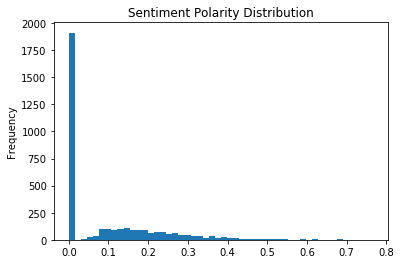

In [197]:
df_train['pos'].plot(
    kind='hist',
    bins=50,
#     xTitle='polarity',
#     linecolor='black',
#     yTitle='count',
    title='Sentiment Polarity Distribution')

(array([1980.,  496.,  408.,  278.,  142.,   78.,   23.,   14.,    8.,
           3.]),
 array([0.    , 0.0767, 0.1534, 0.2301, 0.3068, 0.3835, 0.4602, 0.5369,
        0.6136, 0.6903, 0.767 ]),
 <a list of 10 Patch objects>)

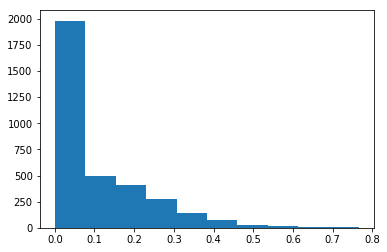

In [199]:
import matplotlib.pyplot as plt 
plt.hist(df_train["pos"]) 
    
  

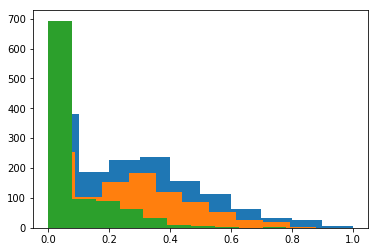

In [202]:
import matplotlib.pyplot as plt 

plt.hist(df_train.loc[df_train['class'] == 0]["neg"]) 
plt.hist(df_train.loc[df_train['class'] == 1]["neg"]) 
plt.hist(df_train.loc[df_train['class'] == 2]["neg"]) 
plt.show()

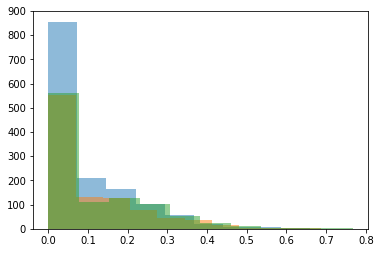

In [207]:
plt.hist(df_train.loc[df_train['class'] == 0]["pos"], alpha=0.5) 
plt.hist(df_train.loc[df_train['class'] == 1]["pos"],alpha=0.5) 
plt.hist(df_train.loc[df_train['class'] == 2]["pos"],alpha=0.5) 
plt.show()

(array([1430.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
        1000.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

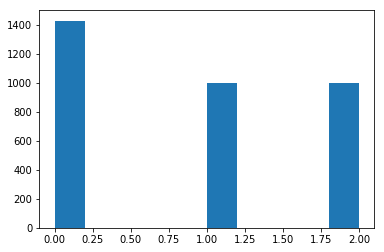

In [208]:
plt.hist(df_train['class']) 

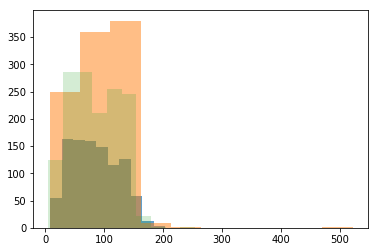

In [215]:
plt.hist(df_train.loc[df_train['class'] == 1]["len"],alpha=0.7) 
plt.hist(df_train.loc[df_train['class'] == 2]["len"],alpha=0.5) 
plt.hist(df_train.loc[df_train['class'] == 0]["len"], alpha=0.2) 
plt.show()

In [0]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]



bitch 436
rt 341
you 299
the 223
to 213
that 159
my 159
and 154
bitches 144
hoes 124
be 122
me 121
in 121
like 120
co 111
128514 110
it 108
http 103
pussy 98
hoe 98


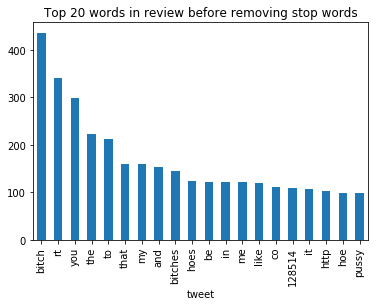

In [217]:
temp_df=df_train.loc[df_train['class'] == 1]["tweet"]
common_words = get_top_n_words(temp_df, 20)
for word, freq in common_words:
    print(word, freq)  
df1 = pd.DataFrame(common_words, columns = ['tweet' , 'count'])
df1.groupby('tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in review before removing stop words')


you 505
the 388
rt 328
to 323
and 234
bitch 209
is 205
that 196
faggot 191
like 169
in 163
of 153
my 145
nigga 140
ass 138
be 131
me 127
white 127
co 126
all 126


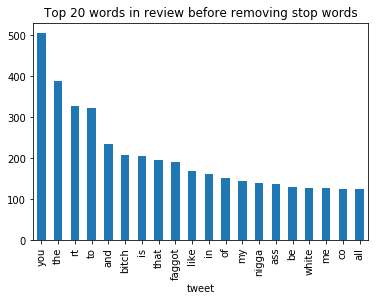

In [218]:
temp_df=df_train.loc[df_train['class'] == 0]["tweet"]
common_words = get_top_n_words(temp_df, 20)
for word, freq in common_words:
    print(word, freq)  
df1 = pd.DataFrame(common_words, columns = ['tweet' , 'count'])
df1.groupby('tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in review before removing stop words')


the 440
rt 331
to 265
http 227
co 215
and 209
trash 181
in 175
is 170
of 153
you 153
it 140
that 134
my 111
for 109
on 105
8230 95
me 86
this 82
be 81


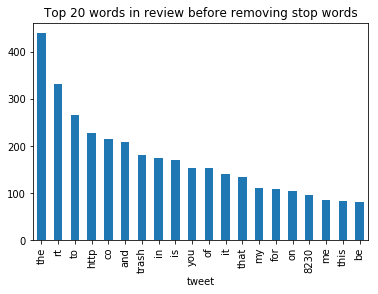

In [219]:
temp_df=df_train.loc[df_train['class'] == 2]["tweet"]
common_words = get_top_n_words(temp_df, 20)
for word, freq in common_words:
    print(word, freq)  
df1 = pd.DataFrame(common_words, columns = ['tweet' , 'count'])
df1.groupby('tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in review before removing stop words')


In [0]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]



rt 328
bitch 209
faggot 191
like 169
nigga 140
ass 138
white 127
fuck 121
http 117
trash 113
nigger 112
128514 96
fucking 95
don 77
fag 76
niggas 76
just 75
8221 66
8220 64
faggots 62


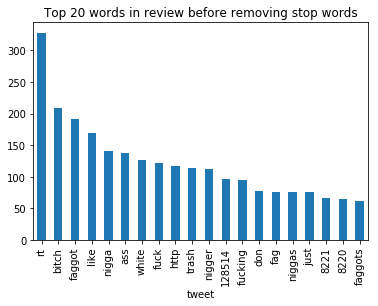

In [226]:
temp_df=df_train.loc[df_train['class'] == 0]["tweet"]
common_words = get_top_n_words(temp_df, 20)
for word, freq in common_words:
    print(word, freq)  
df1 = pd.DataFrame(common_words, columns = ['tweet' , 'count'])
df1.groupby('tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in review before removing stop words')


bitch 436
rt 341
bitches 144
hoes 124
like 120
128514 110
http 103
pussy 98
hoe 98
ass 86
don 75
just 75
8220 72
fuck 72
8221 70
shit 65
ain 58
nigga 53
got 52
lol 49


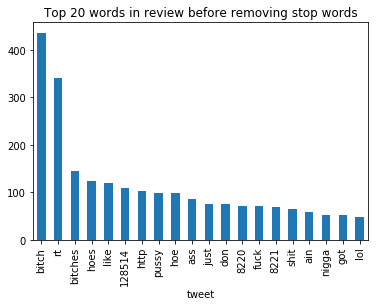

In [224]:
temp_df=df_train.loc[df_train['class'] == 1]["tweet"]
common_words = get_top_n_words(temp_df, 20)
for word, freq in common_words:
    print(word, freq)  
df1 = pd.DataFrame(common_words, columns = ['tweet' , 'count'])
df1.groupby('tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in review before removing stop words')


rt 331
http 227
trash 181
8230 95
bird 79
like 76
charlie 57
128514 57
yankees 56
just 55
yellow 54
birds 44
8220 43
don 42
amp 40
8221 40
lol 35
colored 33
ghetto 31
monkey 31


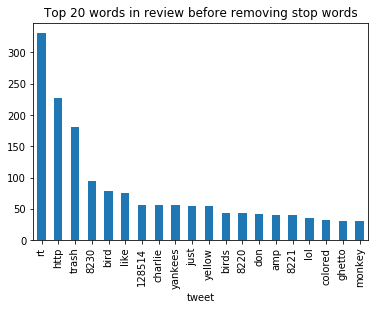

In [225]:
temp_df=df_train.loc[df_train['class'] == 2]["tweet"]
common_words = get_top_n_words(temp_df, 20)
for word, freq in common_words:
    print(word, freq)  
df1 = pd.DataFrame(common_words, columns = ['tweet' , 'count'])
df1.groupby('tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in review before removing stop words')


##Bigrams

In [0]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

white trash 62
128514 128514 49
ass nigga 23
look like 17
bitch ass 15
fucking faggot 11
faggot ass 10
bitch nigga 10
looks like 9
happy birthday 8
fuck bitch 8
white people 8
don like 8
ass niggas 8
nigga bitch 8
http 8230 7
128557 128557 7
like bitch 7
ass bitch 7
black people 7


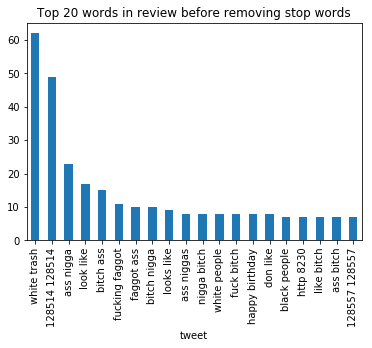

In [228]:
temp_df=df_train.loc[df_train['class'] == 0]["tweet"]
common_words = get_top_n_words(temp_df, 20)
for word, freq in common_words:
    print(word, freq)  
df1 = pd.DataFrame(common_words, columns = ['tweet' , 'count'])
df1.groupby('tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in review before removing stop words')


128514 128514 30
http 8230 20
lt lt 12
flappy bird 10
charlie crist 9
early bird 8
ho 8230 8
charlie sheen 8
look like 7
trash talk 7
1575 1604 7
gt gt 7
derek jeter 6
charlie brown 6
9733 best 6
best asian 6
asian massage 6
park slope 6
slope rated 6
rated spa 6


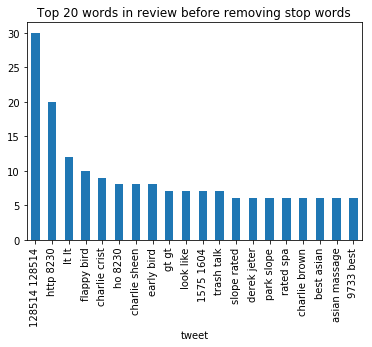

In [229]:
temp_df=df_train.loc[df_train['class'] == 2]["tweet"]
common_words = get_top_n_words(temp_df, 20)
for word, freq in common_words:
    print(word, freq)  
df1 = pd.DataFrame(common_words, columns = ['tweet' , 'count'])
df1.groupby('tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in review before removing stop words')


128514 128514 52
like bitch 14
bitch ass 14
cunt cunt 14
ass bitch 10
yo bitch 9
9986 65039 9
bitch like 8
little bitch 8
bitch http 8
65039 9986 8
don fuck 7
don like 7
don know 7
bad bitch 7
bitch ain 6
ain shit 6
bitch don 6
just like 6
bitch nigga 6


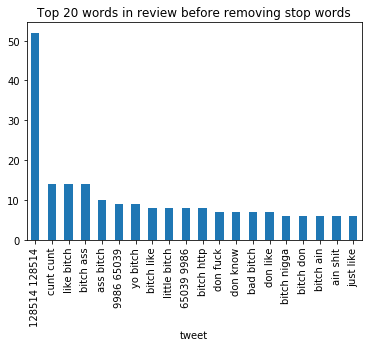

In [230]:
temp_df=df_train.loc[df_train['class'] == 1]["tweet"]
common_words = get_top_n_words(temp_df, 20)
for word, freq in common_words:
    print(word, freq)  
df1 = pd.DataFrame(common_words, columns = ['tweet' , 'count'])
df1.groupby('tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in review before removing stop words')


#Trigrams

In [0]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]



128514 128514 128514 23
bitch ass nigga 7
nigga nigga nigga 4
creepy ass cracker 3
happy birthday faggot 3
128557 128557 128557 3
pussy ass nigga 3
softestmuffin _tee13 torahblaze 3
means white trash 3
got niggas amp 3
da colored folk 3
uncle tom ass 3
127850 127850 127850 3
128079 128079 128079 3
128077 128077 128077 3
lame nigga lame 2
nigga lame bitch 2
look like fag 2
sizzurp__ bootyacid ilikecats74 2
bootyacid ilikecats74 yopapi_chulo 2


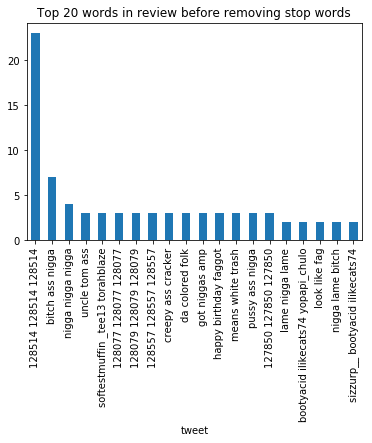

In [232]:
temp_df=df_train.loc[df_train['class'] == 0]["tweet"]
common_words = get_top_n_words(temp_df, 20)
for word, freq in common_words:
    print(word, freq)  
df1 = pd.DataFrame(common_words, columns = ['tweet' , 'count'])
df1.groupby('tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in review before removing stop words')


128514 128514 128514 19
cunt cunt cunt 13
9986 65039 9986 8
65039 9986 65039 8
gt gt gt 4
128588 128588 128588 4
bitch dat ain 3
porn android iphone 3
android iphone ipad 3
iphone ipad sex 3
ipad sex xxx 3
1041210 1041210 1041210 3
128514 128514 http 3
128128 128128 128128 3
128536 128536 128536 3
bae bae bae 3
128525 128525 128525 2
having bitch ain 2
bitch ain goofy 2
ain goofy having 2


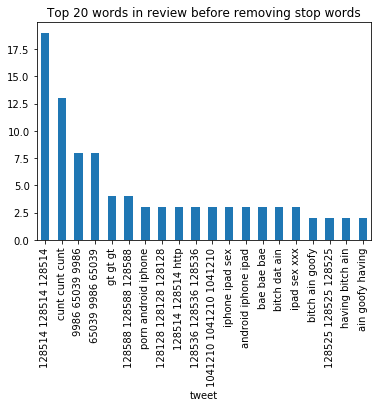

In [233]:
temp_df=df_train.loc[df_train['class'] == 1]["tweet"]
common_words = get_top_n_words(temp_df, 20)
for word, freq in common_words:
    print(word, freq)  
df1 = pd.DataFrame(common_words, columns = ['tweet' , 'count'])
df1.groupby('tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in review before removing stop words')


128514 128514 128514 15
lt lt lt 9
9733 best asian 6
best asian massage 6
park slope rated 6
slope rated spa 6
rated spa 9733 6
spa 9733 718 6
9733 718 622 6
718 622 0221 6
622 0221 24 6
0221 24 http 6
gt gt gt 5
early bird gets 4
bird gets worm 4
asian massage park 4
massage park slope 4
rose colored glasses 3
know abo 8230 3
1585 1575 1604 3


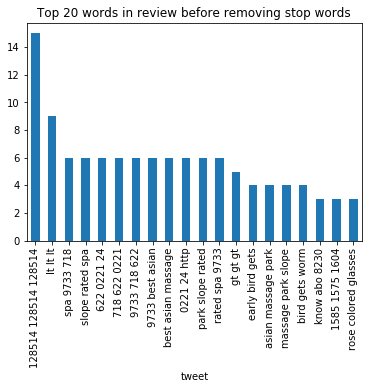

In [234]:
temp_df=df_train.loc[df_train['class'] == 2]["tweet"]
common_words = get_top_n_words(temp_df, 20)
for word, freq in common_words:
    print(word, freq)  
df1 = pd.DataFrame(common_words, columns = ['tweet' , 'count'])
df1.groupby('tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in review before removing stop words')


#POS tags

In [235]:
!pip install TextBlob
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [0]:
import textblob
from textblob import TextBlob

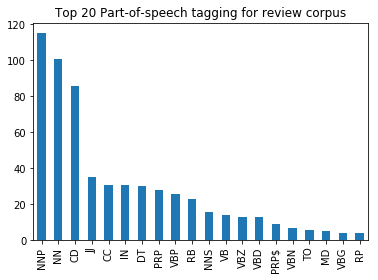

In [237]:
blob = TextBlob(str(df_train['tweet']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.plot(
    kind='bar',
    title='Top 20 Part-of-speech tagging for review corpus')


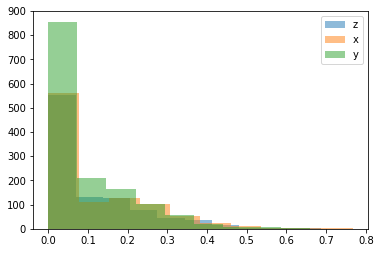

In [239]:
from matplotlib import pyplot

x = df_train.loc[df_train['class'] == 2, 'pos']
y = df_train.loc[df_train['class'] == 0, 'pos']
z = df_train.loc[df_train['class'] == 1, 'pos']

pyplot.hist(z,  label='z', alpha=0.5)
pyplot.hist(x, label='x', alpha=0.5)
pyplot.hist(y,  label='y', alpha=0.5)
pyplot.legend(loc='upper right')
pyplot.show()

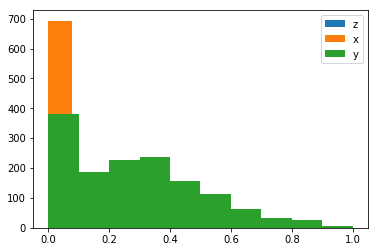

In [240]:
from matplotlib import pyplot

x = df_train.loc[df_train['class'] == 2, 'neg']
y = df_train.loc[df_train['class'] == 0, 'neg']
z = df_train.loc[df_train['class'] == 1, 'neg']

pyplot.hist(z,  label='z')
pyplot.hist(x, label='x')
pyplot.hist(y,  label='y')
pyplot.legend(loc='upper right')
pyplot.show()

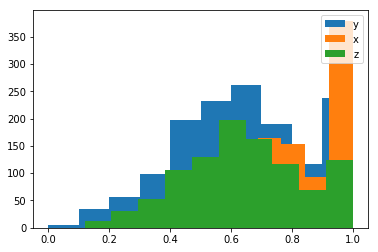

In [247]:
from matplotlib import pyplot

x = df_train.loc[df_train['class'] == 2, 'neu']
y = df_train.loc[df_train['class'] == 0, 'neu']
z = df_train.loc[df_train['class'] == 1, 'neu']


pyplot.hist(y,  label='y')
pyplot.hist(x, label='x')
pyplot.hist(z,  label='z')
pyplot.legend(loc='upper right')
pyplot.show()

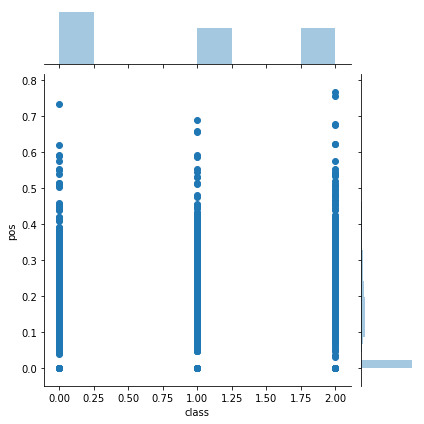

In [248]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df=df_train[["class","pos"]]
sns.jointplot(x="class", y="pos", data=df)

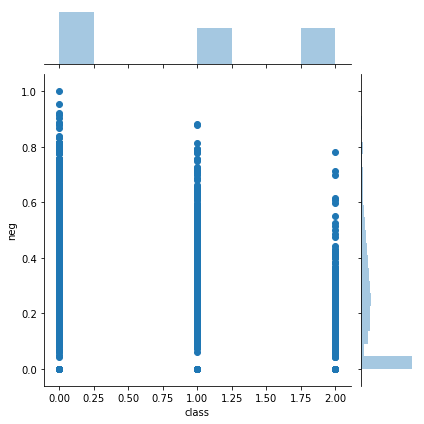

In [249]:
df=df_train[["class","neg"]]
sns.jointplot(x="class", y="neg", data=df)

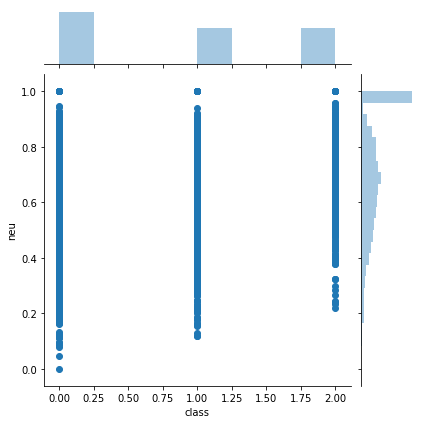

In [250]:
df=df_train[["class","neu"]]
sns.jointplot(x="class", y="neu", data=df)